# Machine Learning Project

## Project description:

### Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that would analyze subscribers behavior and recommend one of Megaline's newer plans: Smart or Ultra. We have access to behavior data about subscribers who have already switched to the new plans.


## Goal of the project:

### Develop a classification model that will pick the right mobile plan with the highest possible accuracy. The threshold for accuracy is 0.75.

## Description of the data:
##### users_behavior.csv
#### Every observation in the dataset contains monthly behavior information about one user. The information given is as follows: 

- `сalls` - number of calls

- `minutes` - total call duration in minutes

- `messages` - number of text messages

- `mb_used` - Internet traffic used in MB

- `is_ultra` - plan for the current month (Ultra - 1, Smart - 0)

## Table of Contents:

[Step 1. Data Exploration and cleaning](#Step-1.-Data-Exploration-and-cleaning)<br>
[Step 2. Data preparation and Model selection](#Step-2.-Data-preparation-and-Model-selection)<br>
[Step 3. Model Sanity check](#Step-3.-Model-Sanity-check)<br>
[Conclusion](#Conclusion)

***

## Step 1. Data Exploration and cleaning

### 1.1. Reading dataset.

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#importing sklearn modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
#reading the "orders_us.csv" dataset
try:
  usersbhv = pd.read_csv('~/Documents/Studying/MachineLearningProject/MLProject/datasets/users_behavior.csv')
except FileNotFoundError:
  usersbhv = pd.read_csv('datasets/users_behavior.csv')
except Exception as e:
  print('An error occurred:', e)
else:
  print('File successfully read.')
#showing basic dataset info
usersbhv.info()
usersbhv.head(10)

File successfully read.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Dataset contains information about 3214 users.

Users with Ultra plan are assigned as "1" and users with Smart plan are assigned as "0".

#### There are no missing values and all columns are clean.

<h3>1.2. Data Exploration</h3>

In [3]:
#groupping users by mobile plan and calculating mean of values of each group
usersbhv.groupby(['is_ultra']).mean().T

is_ultra,0,1
calls,58.463437,73.392893
minutes,405.942952,511.224569
messages,33.384029,49.363452
mb_used,16208.466949,19468.823228


Users on the Ultra plan tend to have higher average usage across all values compared to users on the Smart plan.

In [4]:
#calculating distribution by percentage by each group
percentages = usersbhv.drop(columns = 'is_ultra').groupby(usersbhv['is_ultra']).sum() / usersbhv.drop(columns = 'is_ultra').sum() * 100
percentages.T

is_ultra,0,1
calls,64.319101,35.680899
minutes,64.246300,35.753700
messages,60.480672,39.519328
mb_used,65.325685,34.674315


Although users on the Ultra plan tend to have higher average usage, the Smart plan likely has a significantly larger user base, leading to a greater overall contribution to the total calls, minutes, messages, and data usage (mb_used) values.

In [5]:
#showing basic stats for each mobile plan for detailed analysis
for group in usersbhv['is_ultra'].unique():
    if group == 1:
        result = 'Ultra'
    else:
        result = 'Smart'
    print("Basic stats for", result, "plan")
    display(usersbhv[usersbhv.is_ultra == group].describe())

Basic stats for Smart plan


,calls,minutes,messages,mb_used,is_ultra
count,2229.000000,2229.000000,2229.000000,2229.000000,2229.0
mean,58.463437,405.942952,33.384029,16208.466949,0.0
std,25.939858,184.512604,28.227876,5870.498853,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,40.000000,274.230000,10.000000,12643.050000,0.0
50%,60.000000,410.560000,28.000000,16506.930000,0.0
75%,76.000000,529.510000,51.000000,20043.060000,0.0
max,198.000000,1390.220000,143.000000,38552.620000,0.0


Basic stats for Ultra plan


,calls,minutes,messages,mb_used,is_ultra
count,985.000000,985.000000,985.000000,985.000000,985.0
mean,73.392893,511.224569,49.363452,19468.823228,1.0
std,43.916853,308.031100,47.804457,10087.178654,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,41.000000,276.030000,6.000000,11770.280000,1.0
50%,74.000000,502.550000,38.000000,19308.010000,1.0
75%,104.000000,730.050000,79.000000,26837.720000,1.0
max,244.000000,1632.060000,224.000000,49745.730000,1.0


#### On average, Ultra users make significantly more calls than Smart users (73.39 vs. 58.46).

- The distribution of calls among Ultra users is more dispersed (higher standard deviation), indicating a broader variety in calling habits. Some make very few calls, while others make many.

- The median call count is also higher for Ultra users, suggesting that they are generally more active in making calls.

- Ultra users spend more time on the phone, averaging 511.22 minutes compared to 405.94 minutes for Smart users.

- There is a greater variation in the number of minutes used among Ultra users, reflecting diverse patterns of usage (with some users consuming much more time than others).

- The median time spent on calls is also higher for Ultra users, indicating that they tend to spend more time talking.
- Ultra users send more messages on average (49.36 vs. 33.38).

- The higher standard deviation in message count suggests a significant variation, where some Ultra users send very few messages while others send far more.

- The median number of messages is higher among Ultra users, showing that even the typical Ultra user sends more messages than the average Smart user.

- Ultra users consume notably more mobile data on average (19,468.82 MB vs. 16,208.47 MB).

- The variation in data usage is significantly higher among Ultra users, with some consuming much larger amounts of data than others.

- The median data usage is also higher for Ultra users, confirming that they generally use more data than Smart users.

The Ultra plan seems to cater to users with greater needs for calls, messaging, and data. The considerable variation in usage among Ultra users implies that the plan offers flexibility, appealing to both heavy and moderate users. On the other hand, the Smart plan is better suited for users with more stable and typically lower usage requirements.

This analysis can guide marketing strategies, such as tailoring campaigns to different user segments based on their usage behaviors or modifying pricing and features to more effectively address the needs of each group.

#### Correlation Matrix

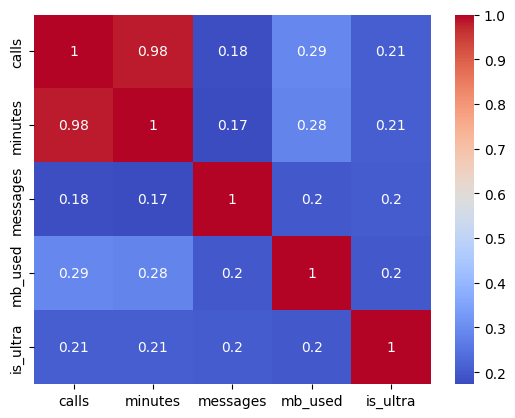

In [6]:
#calculating correlation matrix
correlation_matrix = usersbhv.corr()

# visualize the correlation matrix using a heatmap
sns.heatmap(correlation_matrix, annot = True, cmap = 'coolwarm')
plt.show()

The heatmap above illustrates the correlation matrix between the variables: calls, minutes, messages, mb_used, and is_ultra. The color intensity represents the correlation strength, ranging from red (strong positive correlation) to blue (strong negative correlation).

Calls and minutes display a very strong positive correlation, shown by the deep red color. This suggests that users who make more calls are likely to spend more time on the phone.
Messages and minutes exhibit a moderate positive correlation, indicating that users who send more messages generally also have longer call durations.

There is a moderate positive correlation between mb_used and minutes, suggesting that users who consume more data also tend to spend more time on calls.

The relationships between calls, minutes, messages, mb_used, and is_ultra are relatively weak, as reflected by the lighter colors. This indicates that these variables do not have a strong impact on data usage or subscription to the Ultra plan.


<h2>Step 2. Data preparation and Model selection</h2>

### 2.1. Splitting data and Selecting model

#### Dataset dividing into three parts: training (60%), validation (20%), and test sets (20%)
Splitting as 60% training, 20% validation, and 20% test to balance sufficient training data with reliable validation/testing.

In [7]:
#splitting features and target
X = usersbhv.drop(columns=['is_ultra'])
y = usersbhv['is_ultra']

#train (60%), validation (20%), and test (20%) splitting
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

#displaying the sizes of the splits
split_sizes = {
    "Training Set": len(X_train),
    "Validation Set": len(X_valid),
    "Test Set": len(X_test)
}

split_sizes

{'Training Set': 1928, 'Validation Set': 643, 'Test Set': 643}

#### Selecting model with best accuracy
Between Logistic Regression, Decision Tree and Random Forest

In [8]:
#defining models to evaluate
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100)
}

#training and evaluating models on the validation set
model_results = {}
for model_name, model in models.items():
    #training the model
    model.fit(X_train, y_train)
    #predicting on the validation set
    y_valid_pred = model.predict(X_valid)
    #calculating accuracy
    accuracy = accuracy_score(y_valid, y_valid_pred)
    model_results[model_name] = accuracy

model_results

{'Logistic Regression': 0.7045101088646968,
 'Decision Tree': 0.7465007776049767,
 'Random Forest': 0.8009331259720062}

#### Model Comparison Results

#### The models achieved accuracy on the validation set:
- `Logistic Regression`: 70.45%

- `Decision Tree`: 74.65%

- `Random Forest`: 80.09%

After training the models on the training set and evaluating their accuracy on the validation set, the Random Forest model was chosen for further optimization using GridSearchCV due to its superior initial performance.

### 2.2. Optimizing model using hyperparameter tuning

#### Searching and tuning hyperparameters to achieve better accuracy using GridSearchCV
- `n_estimators` - number of trees in the forest.
- `max_depth` - maximum depth of each tree.
- `min_samples_split` - minimum samples required to split a node.
- `min_samples_leaf` - minimum samples required to be at a leaf node.

While defining parameter grid these exact values were chosen in terms of balance thorough exploration with efficiency. It tests key parameters like tree size `(n_estimators)`, `depth (max_depth)`, and `split constraints (min_samples_split, min_samples_leaf)` to evaluate the trade-off between model complexity and generalization. Baseline values ensure default behaviors are tested, while moderated values promote simpler, more robust models. The grid ensures a comprehensive yet computationally efficient search for optimal hyperparameters.

In [9]:
#defining the parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

#initializing the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

#initializing GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=rf_model, param_grid=param_grid, cv=3, scoring="accuracy", verbose=1, n_jobs=-1
)

#performing hyperparameter tuning on the training set
grid_search.fit(X_train, y_train)

#extracting the best hyperparameters and the corresponding accuracy
best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 3 folds for each of 81 candidates, totalling 243 fits


({'max_depth': 10,
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 50},
 0.809124221385671)

#### The best hyperparameters for the Random Forest model are:
- `max_depth`: 10

- `min_samples_leaf`: 1

- `min_samples_split`: 5

- `n_estimators`: 50
#### The cross-validation accuracy for this configuration is 80.91%.

#### Retraining and evaluating optimized Random Forest model using these hyperparameters on the training set.

In [10]:
#training the optimized Random Forest model with the best hyperparameters
optimized_rf_model = RandomForestClassifier(
    random_state=42,
    max_depth=10,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=50
)

#training the model on the training set
optimized_rf_model.fit(X_train, y_train)

#predicting on the test set
y_test_pred_optimized = optimized_rf_model.predict(X_test)

#calculating accuracy on the test set
optimized_test_accuracy = accuracy_score(y_test, y_test_pred_optimized)

optimized_test_accuracy

0.8149300155520995

#### The optimized Random Forest model achieved an accuracy of 81.49% on the test set.

### Summary of Step 2

- To evaluate the quality of different models three algorithms were compared: Logistic Regression, Decision Tree, and Random Forest. Each model was trained on the training dataset and evaluated on the validation set using accuracy as the metric. The Random Forest model outperformed the others with a validation accuracy of 80.09% in its default configuration.

- `GridSearchCV` was used to systematically tune the hyperparameters of the Random Forest model. The parameters tuned included the `number of trees (n_estimators)`, `maximum tree depth (max_depth)`, `minimum samples required to split a node (min_samples_split)`, and `minimum samples required to be at a leaf node (min_samples_leaf)`. After testing various combinations with cross-validation, the optimal hyperparameters were identified as `n_estimators = 50`, `max_depth = 10`, `min_samples_split = 5`, and `min_samples_leaf = 1`. This tuning process improved the cross-validation accuracy to 80.91%

- Through this process it was confirmed that Random Forest is the best-performing model for this dataset, and its optimized configuration was used for final testing on the test set and achieved accuracy of 81.49% which exceeded threshold of 75%.

## Step 3. Model Sanity check

### 3.1. Random input testing
Providing model with randomly generated data to observe its predictions. Ensures the model doesn’t make confident predictions for unrealistic data.

In [11]:
#generating data with the same feature ranges
random_data = pd.DataFrame({
    'calls': np.random.randint(0, 250, 10),  #calls range: 0-244
    'minutes': np.random.uniform(0, 1650, 10),  #minutes range: 0-1632
    'messages': np.random.randint(0, 230, 10),  #messages range: 0-224
    'mb_used': np.random.uniform(0, 50000, 10)  #MB used range: 0-49745
})

#predicting on the random data
random_predictions = optimized_rf_model.predict(random_data)

#combining the random data and predictions for review
random_test_results = random_data.copy()
random_test_results['Predicted Plan'] = random_predictions

random_test_results

,calls,minutes,messages,mb_used,Predicted Plan
0,73,764.561266,24,2578.806517,1
1,218,263.379638,228,35796.031143,1
2,79,913.726951,211,6077.461947,1
3,193,312.322815,66,25930.228859,0
4,168,414.728489,221,26647.904791,1
5,77,681.310961,127,35974.036881,1
6,1,1086.454907,12,11699.458346,0
7,175,1197.420466,198,38347.317860,1
8,169,614.787614,213,7448.388993,1
9,99,767.361271,15,30802.453311,1


- The model predicts most randomly generated inputs as Ultra (Plan 1), indicating higher thresholds for features like `calls`, `minutes`, or `mb_used`.
- An outlier input (e.g., low calls and minutes, moderate MB usage) was predicted as Smart.

### 3.2. Edge case testing
Test with extreme values for features (e.g., very high or very low usage). Ensures the model handles edge cases logically.

In [12]:
#extreme values for testing
edge_case_data = pd.DataFrame({
    'calls': [0, 250],  #min and max calls
    'minutes': [0, 1650],  #min and max minutes
    'messages': [0, 224],  #min and max messages
    'mb_used': [0, 50000]  #min and max MB used
})

#predicting on the edge case data
edge_case_predictions = optimized_rf_model.predict(edge_case_data)

#combining the edge case data and predictions for review
edge_case_results = edge_case_data.copy()
edge_case_results['Predicted Plan'] = edge_case_predictions

edge_case_results

,calls,minutes,messages,mb_used,Predicted Plan
0,0,0,0,0,1
1,250,1650,224,50000,1


- High values across all features (calls, minutes, messages, mb_used) predict the Ultra plan as expected, aligning with the logical assumption that heavy usage corresponds to Ultra.
- Even with minimal usage across all features (calls, minutes, messages, mb_used = 0), the model predicts the Ultra plan. This suggests the model might not properly handle very low feature values.

### 3.3 Sensitivity testing
Slightly vary the input data to check if the predictions change drastically. Ensures the model is not overly sensitive to minor variations.

In [13]:
#varying a single feature while keeping others constant
sensitivity_data = pd.DataFrame({
    'calls': [50] * 10,  #constant value for calls
    'minutes': np.linspace(0, 1650, 10),  #varying minutes
    'messages': [50] * 10,  #constant value for messages
    'mb_used': [10000] * 10  #constant value for MB used
})

#predicting on the sensitivity test data
sensitivity_predictions = optimized_rf_model.predict(sensitivity_data)

#combining the sensitivity test data and predictions for review
sensitivity_results = sensitivity_data.copy()
sensitivity_results['Predicted Plan'] = sensitivity_predictions

sensitivity_results

,calls,minutes,messages,mb_used,Predicted Plan
0,50,0.000000,50,10000,1
1,50,183.333333,50,10000,0
2,50,366.666667,50,10000,0
3,50,550.000000,50,10000,0
4,50,733.333333,50,10000,1
5,50,916.666667,50,10000,1
6,50,1100.000000,50,10000,1
7,50,1283.333333,50,10000,1
8,50,1466.666667,50,10000,1
9,50,1650.000000,50,10000,1


- The model predicts Smart (Plan 0) for moderate usage (minutes ~183–550) but switches to Ultra (Plan 1) as minutes exceed ~733. This indicates the model is sensitive to changes in minutes and adjusts its predictions logically.
- The predictions transition smoothly without abrupt changes, which suggests the model’s response is reasonable.

## Conclusion

- The goal of this project was to develop a model to recommend one of two mobile plans, Smart or Ultra, based on user behavior. After evaluating multiple models, including Logistic Regression, Decision Tree, and Random Forest, the Random Forest model was selected for its superior performance.

- Through hyperparameter tuning using `GridSearchCV`, the model achieved a cross-validation accuracy of 80.91%. When tested on unseen data, the optimized model delivered a test accuracy of 81.49%, exceeding the target threshold of 75%.

- Sanity checks confirmed that the model behaves logically in most scenarios, though improvements may be needed to handle edge cases like extreme low usage. Overall, the project successfully met its objectives, providing a robust solution for recommending mobile plans.